In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sys
import time
import datetime
import copy

sys.path.append("/Users/giovanni/MyPackages/myutils/myutils/")

from myutils import get_info
from myplots import *
from mytools import *

%matplotlib inline
%connect_info


font = {'family' : 'normal',
'size'   : 9}
plt.rc('font', **font)
#plt.rcParams['savefig.dpi']=200


{
  "stdin_port": 49860, 
  "ip": "127.0.0.1", 
  "control_port": 49861, 
  "hb_port": 49862, 
  "signature_scheme": "hmac-sha256", 
  "key": "2775f8b3-0ea1-4943-99ba-ab6fe9a8802e", 
  "kernel_name": "", 
  "shell_port": 49858, 
  "transport": "tcp", 
  "iopub_port": 49859
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /Users/giovanni/Library/Jupyter/runtime/kernel-12f35c43-f0ea-4beb-9fa0-59eb03bcc64d.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [32]:
def check_for_nan(df):
    count = 0
    nulllables = []
    for i,j in enumerate(df.columns):
        a = len(df[ df[j].isnull()] )
        b = df[j]==np.inf
        if a!=0:
            count += 1
            nulllables.append(j)
            print j,i
    
    if count!=0:
        print nulllables
        return False
    else:
        return True

# Target selection 

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

In [34]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.set_index('ID', inplace=True)
test.set_index('ID', inplace=True)

print train['target'].value_counts()
N = train['target'].value_counts()[1]
print train.shape[0], train.shape[1]
print test.shape[0], train.shape[1]

1    87021
0    27300
Name: target, dtype: int64
114321 132
114393 132


In [35]:
ids = train.index

In [36]:
savetrain = copy.copy(train)
mask1 = train['target']==1
mask0 = train['target']==0
N = 5000
#train = pd.concat([train[mask1].sample(N), train[mask0].sample(N)])
Y = train['target']
train.drop('target', inplace=True, axis=1)
print train.shape[0], train.shape[1]

114321 131


In [37]:
map_feat = {}
map_feat['ordinal'] = []
map_feat['binary'] = []
map_feat['multicategorical'] = []
map_feat['unary'] = []
map_feat['mixed'] = []
map_feat['continuous'] = []


null = []
for i in train.columns:
    L = len(train[i].unique())
    if L==2:
        map_feat['binary'] += [i]
        print 'binary', i, (train[i].isnull()).sum()*100./train.shape[0], len(train[i].unique())
        print 'max', train[i].max(), 'min', train[i].min()

    if L>2 and L<10 or train[i].dtype=='O':
        map_feat['multicategorical'] += [i]
        print 'multicategorical', i, (train[i].isnull()).sum()*100./train.shape[0], len(train[i].unique())
        print 'max', train[i].max(), 'min', train[i].min()
    
    if L>=10 and train[i].dtype!='O':
        map_feat['ordinal'] += [i]
        print 'ordinal', i, (train[i].isnull()).sum()*100./train.shape[0], len(train[i].unique())
        print 'max', train[i].max(), 'min', train[i].min()
        
    elif L>=10 and train[i].dtype=='O':
        map_feat['mixed'] += [i]
        print 'mixed', i, (train[i].isnull()).sum()*100./train.shape[0], len(train[i].unique())
        print 'max', train[i].max(), 'min', train[i].min()
        
    elif L>=50 and train[i].dtype!='O':
        map_feat['continuous'] += [i]
        print 'continuous', i, (train[i].isnull()).sum()*100./train.shape[0], len(train[i].unique())
        print 'max', train[i].max(), 'min', train[i].min()
        
    if train[i].isnull().sum()==train.shape[0]:
        null += [i]
    print "\n"

ordinal v1 43.589541729 64488
max 20.0000006294 min -9.99649701427e-07


ordinal v2 43.5580514516 64525
max 19.9999999087 min -9.81761449207e-07


multicategorical v3 3.02394135811 4
max C min inf


ordinal v4 43.5580514516 64525
max 19.9999997446 min -6.47592938974e-07


ordinal v5 42.532867977 65672
max 20.0000003539 min -5.28706773973e-07


ordinal v6 43.589541729 64488
max 20.0000005964 min -9.05509144998e-07


ordinal v7 43.589541729 64490
max 19.9999998141 min -9.46876549674e-07


ordinal v8 42.5284943274 65689
max 20.000000997 min -7.78377810758e-07


ordinal v9 43.6061615976 64452
max 20.0000007502 min -9.82875684434e-07


ordinal v10 0.0734773138793 112486
max 18.5339164478 min -9.87531659989e-07


ordinal v11 43.5930406487 64478
max 20.0000009233 min -1.45906182755e-07


ordinal v12 0.0752267737336 114234
max 18.7105503906 min 5.14322389107e-07


ordinal v13 43.589541729 64489
max 20.0000009059 min -8.46488878755e-07


ordinal v14 0.00349891970854 110473
max 19.9999996125 min

In [38]:
# L = len(map_feat['multicategorical'])
# nrows = L/2 if L%2==0 else (L+1)/2
# fig = plt.figure(figsize=(12, nrows * 6))

# for i,col in enumerate(map_feat['multicategorical']):

#     print col, train[col].notnull().sum()*100./train.shape[0]

#     ax = fig.add_subplot(nrows, 2, i+1)
#     temp = train[col].value_counts()/train.shape[0]
#     ax.bar(range(len(temp)), temp.values, width=0.5, color='r')
#     temp2 = test[col].value_counts()/test.shape[0]
#     ax.bar(np.arange(len(temp2))+0.5, temp2.values,  width=0.5, color='g')
#     ax.set_title(col)

# plt.show()

In [39]:
# L = len(map_feat['mixed'])
# nrows = L/2 if L%2==0 else (L+1)/2
# fig = plt.figure(figsize=(12, nrows * 6))

# for i,col in enumerate(map_feat['mixed']):

#     print col, train[col].notnull().sum()*100./train.shape[0]

#     ax = fig.add_subplot(nrows, 2, i+1)
#     temp = train[col].value_counts()/train.shape[0]
#     ax.bar(range(len(temp)), temp.values, width=0.5, color='r')
#     temp2 = test[col].value_counts()/test.shape[0]
#     ax.bar(np.arange(len(temp2))+0.5, temp2.values,  width=0.5, color='g')
#     ax.set_title(col)

# plt.show()

In [40]:
# L = len(map_feat['ordinal'])
# nrows = L/2 if L%2==0 else (L+1)/2
# fig = plt.figure(figsize=(12, nrows * 6))

# for i,col in enumerate(map_feat['ordinal']):

#     print col, train[col].notnull().sum()*100./train.shape[0]

#     ax = fig.add_subplot(nrows, 2, i+1)
#     try:
#         mini = train[col].min()
#         maxi = train[col].max()
        
#         train[col].plot(kind='hist', ax=ax, range=(mini, maxi), normed=True, histtype='step', lw=2, label='train')
#         test[col].plot(kind='hist', ax=ax, range=(mini, maxi), normed=True, histtype='step', lw=2, label='test')
#         ax.set_title(col)
#     except:
#         pass

# plt.show()

In [41]:
print train.shape
train = train.dropna(axis=0, how='all')
print train.shape
train.head()

(114321, 131)
(114321, 131)


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
ID,,,,,,,,,,,,,,,,,,,,,
3,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
4,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
5,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
6,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
8,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.050328,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v123,v124,v125,v126,v127,v128,v129,v130,v131,sum
ID,,,,,,,,,,,,,,,,,,,,,
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,130
4,False,False,True,False,True,False,False,True,False,True,...,False,True,True,False,False,True,True,False,False,50
5,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,129
6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,130
8,False,False,True,False,False,False,False,False,False,True,...,False,False,True,False,False,False,True,False,False,29


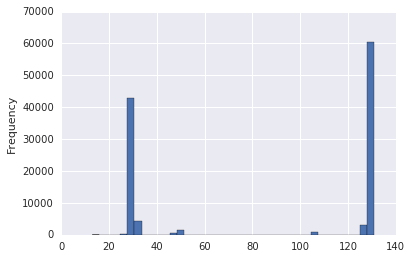

In [55]:
temp = pd.DataFrame()

cols = train.columns.tolist()
for i in cols:
    temp = pd.concat([temp, train[i].notnull()], axis=1)

temp.sum(axis=1).plot(kind='hist', bins=40)
temp['sum'] = temp.sum(axis=1)
temp.head()

In [56]:
print temp.shape[0], train.shape[0] 
train1 = train[temp['sum']>80]
train2 = train[temp['sum']<80]
train1.to_csv("train1.csv", index_col=0)
train2.to_csv("train2.csv", index_col=0)

114321 114321
64489
49832


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
ID,,,,,,,,,,,,,,,,,,,,,
0,1.375465e+00,11.361141,C,4.200778,6.57700,2.081784,1.784386,0.011094,9.523810,1.312911,...,7.619048,1.815241,1.112270e-07,AF,1.292368,3.903345,1.485925,0,2.333334,1.428572e+00
1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.291029,...,NaN,NaN,NaN,I,NaN,NaN,NaN,0,NaN,NaN
2,-4.903407e-07,8.201529,C,4.544371,6.55010,1.558442,2.467532,0.007164,7.142858,1.575492,...,5.714286,1.970928,1.412265e-02,AV,1.128724,5.844156,1.475892,0,1.263157,-6.380022e-07
7,2.661870e+00,3.041241,C,1.657216,9.77308,2.078337,1.430855,1.252157,7.959596,1.575493,...,4.404040,8.163614,1.100329e+00,B,1.988688,1.558753,2.448814,0,5.385474,1.493777e+00
10,1.252822e+00,11.283352,C,4.638388,8.52051,2.302484,3.510159,0.074263,7.612904,1.050328,...,6.580644,1.325654,2.584588e-01,A,1.863796,2.666478,2.374275,0,0.681672,2.264151e+00


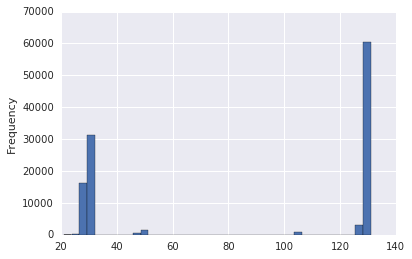

In [59]:
null_dic = {}
temp = pd.DataFrame()

for i in cols:
    temp = pd.concat([temp, test[i].notnull()], axis=1)

temp.sum(axis=1).plot(kind='hist', bins=40)
temp['sum'] = temp.sum(axis=1)
test.head()

In [60]:
test1 = test[temp['sum']>80]
test2 = test[temp['sum']<80]
test1.to_csv("test1.csv", index_col=0)
test2.to_csv("test2.csv", index_col=0)

In [46]:
qwritub+=1

NameError: name 'qwritub' is not defined

In [61]:
class Processor_ar(object):

    def __init__(self, features_dict, prescaled=False, methods = 'default', onehot=False):

        for i in features_dict.keys():
            setattr(self, i, features_dict[i])

        self.ordinal = self.ordinal 
        self.categorical = self.multicategorical + self.binary
        features = []
        
        for i in features_dict.keys():
            features += features_dict[i]

        self.features = list(set(features))

        if methods == 'default':
            self.methods = {'ordinal': 'mode',
                            'multicategorical': 'mean'}
        else:
            if isinstance(methods, dict):
                self.methods = methods

        self.prescaled = prescaled


    def fit(self, X, Y):

        #X.drop(self.empty + self.date + self.location + self.misc, axis=1, inplace=True)

        pipe = []

        if self.unary:
            X[self.unary] = X[self.unary].fillna(0, axis=0)

        self.means = {}
        self.stds = {}

        if self.prescaled==True:
            for col in self.ordinal:

                mask = X[col].notnull()
                mean = X.ix[mask, col].mean()
                std = X.ix[mask, col].std()
                self.means[col] = mean
                self.stds[col] = std
                if std==0:
                    print "std = 0"
                    self.stds[col] = 1
                    
        else:

            if self.likelihood:
                ordinal_imputer_likelihood = preprocessing.Imputer(self.likelihood, strategy=self.methods['likelihood'])
                pipe += [('ordinal1', ordinal_imputer_likelihood)]
                self.ordinal_imputer_likelihood = ordinal_imputer_likelihood


            if self.continuous:
                ordinal_imputer_continuous = preprocessing.Imputer(self.continuous, strategy=self.methods['continuous'])
                pipe += [('ordinal2', ordinal_imputer_continuous)]
                self.ordinal_imputer_continuous = ordinal_imputer_continuous


            if self.ordinal:
                ordinal_imputer_ordinal = preprocessing.Imputer(self.ordinal, strategy=self.methods['ordinal'])
                pipe += [('ordinal3', ordinal_imputer_ordinal)]
                self.ordinal_imputer_ordinal = ordinal_imputer_ordinal


        if self.onehot==False:
            categorical_encoder = sclmodels.preprocessing.CategoricalEncoder(
            self.multicategorical + self.binary, scheme=self.methods['multicategorical'], log_centre=True, min_category_size=10, map_nulls=True
        )
            pipe += [('categorical_encoder', categorical_encoder)]
            self.pipe = Pipeline(pipe)
            self.categorical_encoder = categorical_encoder

        else:
            categorical_encoder = sclmodels.preprocessing.CategoricalEncoder(
            self.multicategorical, scheme="mean", log_centre=True, min_category_size=10, map_nulls=True
        )
            if self.binary:
                onehotencoder = sclmodels.preprocessing.OneHotEncoder(self.binary, map_nulls=True)

            pipe += [('onehotencoder', onehotencoder)]

            self.pipe = Pipeline(pipe)

        X = self.pipe.fit_transform(X, Y)

    def fit_transform(self, X, Y):

        #X.drop(self.empty + self.date + self.location + self.misc, axis=1, inplace=True)
        pipe = []

        if self.unary:
            X[self.unary] = X[self.unary].fillna(0, axis=0)

        self.means = {}
        self.stds = {}
        if self.prescaled==True:

            for col in self.ordinal:

                mask = X[col].notnull()
                mean = X.ix[mask, col].mean()
                std = X.ix[mask, col].std()
                self.means[col] = mean
                self.stds[col] = std
                if std==0:
                    self.stds[col] = 1             
                X.ix[mask, col] = (X.ix[mask, col] - self.means[col])/self.stds[col]
                X[col].fillna(0, inplace=True)

        else:


            if self.likelihood:
                ordinal_imputer_likelihood = preprocessing.Imputer(self.likelihood,self.methods['likelihood'])
                pipe += [('ordinal1', ordinal_imputer_likelihood)]
                self.ordinal_imputer_likelihood = ordinal_imputer_likelihood


            if self.continuous:
                ordinal_imputer_continuous = preprocessing.Imputer(self.continuous, strategy=self.methods['continuous'])
                pipe += [('ordinal2', ordinal_imputer_continuous)]
                self.ordinal_imputer_continuous = ordinal_imputer_continuous


            if self.ordinal:
                ordinal_imputer_ordinal = preprocessing.Imputer(self.ordinal, strategy=self.methods['ordinal'])
                pipe += [('ordinal3', ordinal_imputer_ordinal)]
                self.ordinal_imputer_ordinal = ordinal_imputer_ordinal


        categorical_encoder = sclmodels.preprocessing.CategoricalEncoder( self.multicategorical + self.binary, 
                                                                         scheme=self.methods['multicategorical'], 
                                                                         log_centre=False, min_category_size=10, 
                                                                         map_nulls=True )
        pipe += [('categorical_encoder', categorical_encoder)]
        self.pipe = Pipeline(pipe)
        self.categorical_encoder = categorical_encoder

        X = self.pipe.fit_transform(X, Y)

        return X

    def transform(self, X):

        #X.drop(self.empty + self.date + self.location + self.misc, axis=1)

        if self.unary:
            X[self.unary] = X[self.unary].fillna(0, axis=0)

        if self.prescaled==True:

            for col in self.ordinal:

                mask = X[col].notnull()
                X.ix[mask, col] = (X.ix[mask, col] - self.means[col])/self.stds[col]
                X[col].fillna(0, inplace=True)

        X = self.pipe.transform(X)

        return X


In [62]:
train = pd.concat([train[mask1].sample(N), train[mask0].sample(N)])
Y = Y.loc[train.index]

In [63]:
processor = Processor_ar(map_feat, prescaled=True)
X = processor.fit_transform(train, Y)
scaler = StandardScaler()
X.ix[:, processor.categorical] = scaler.fit_transform(X[processor.categorical])

In [64]:
processor.categorical

['v3',
 'v22',
 'v24',
 'v30',
 'v31',
 'v47',
 'v52',
 'v56',
 'v62',
 'v66',
 'v71',
 'v74',
 'v75',
 'v79',
 'v91',
 'v107',
 'v110',
 'v112',
 'v113',
 'v125']

In [65]:
check_for_nan(X)

True

In [66]:
leftout = savetrain[~savetrain.index.isin(train.index)]
leftout.head()

,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
ID,,,,,,,,,,,,,,,,,,,,,
3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [67]:
Y_leftout = leftout['target']
leftout.drop('target', axis=1, inplace=True)
X_leftout = processor.transform(leftout)
X_leftout.ix[:, processor.categorical] = scaler.transform(X_leftout[processor.categorical])

/Users/giovanni/envs/work/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Build the model

In [68]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from collections import OrderedDict
from sklearn.cross_validation import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from evolutionary_search import EvolutionaryAlgorithmSearchCV

In [69]:
params = {'n_estimators': 160,
          'learning_rate': 0.07,
          'max_depth': 5,
          'min_samples_leaf': 9,
          'subsample': 0.5,
          'verbose': 0}

clf = GradientBoostingClassifier(**params)
params = {'n_estimators': 160,
          'learning_rate': 0.07,
          'max_depth': 5,
          'subsample': 0.5}

clf2 = XGBClassifier(**params)
clf3 = LogisticRegression(solver='lbfgs')

models = zip(['GBC', 'XGB'], [clf, clf2])

78


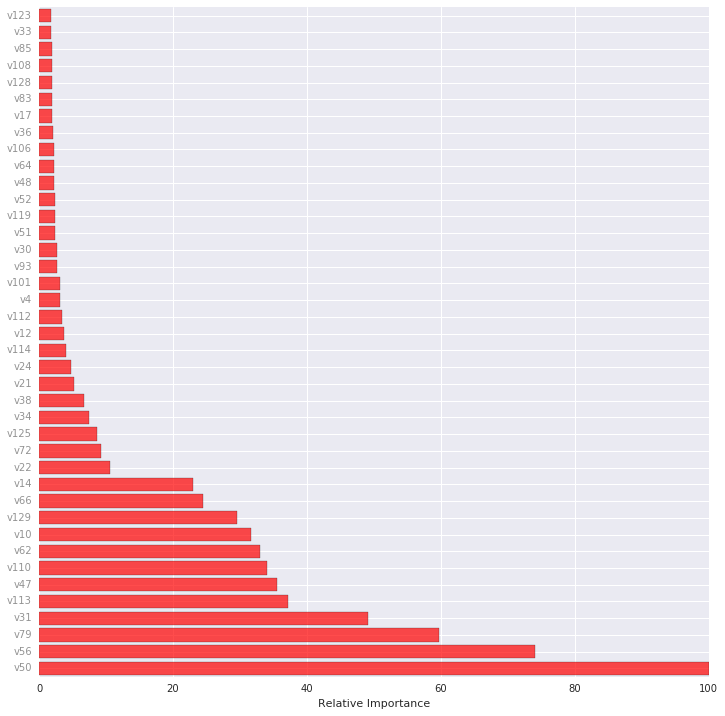

In [70]:
kf = StratifiedKFold( Y, n_folds = 10)
anovafeat = feature_anova(clf, X, Y, n_perc=90)
print len(anovafeat)

In [71]:
clf.fit(X[anovafeat], Y)

GradientBoostingClassifier(init=None, learning_rate=0.07, loss='deviance',
              max_depth=5, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=9, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=160,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

77


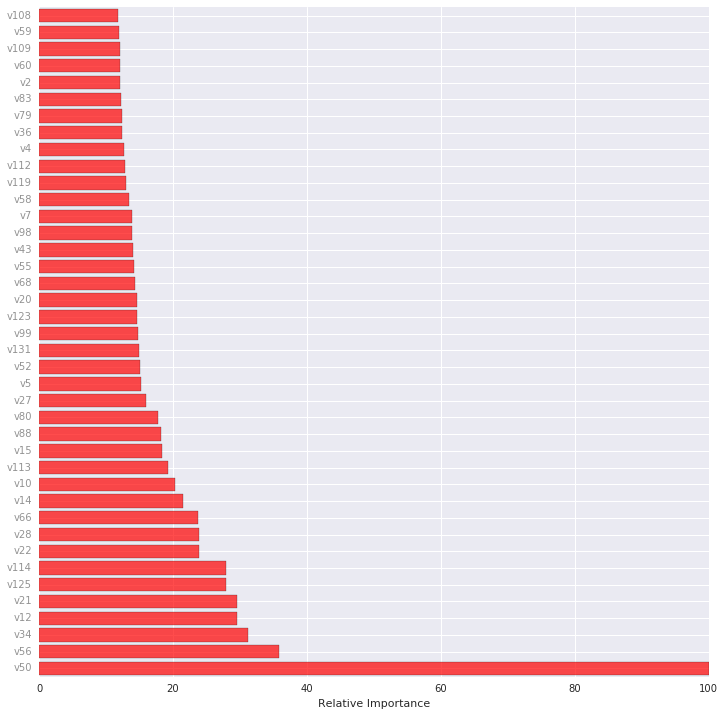

In [72]:
feat1 = plot_feature_importances(clf, anovafeat, n_features=40, threshold=1, append_name='_gbc')
print len(feat1)

In [74]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

paramgrid = { 
            "max_depth": np.arange(3, 10, 1),
            "learning_rate": [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
            "n_estimators": [int(est) for est in np.linspace(100,400,num=20)],
            "subsample" : [0.4, 0.5, 0.6, 0.7, 0.8],
             }


gbc = GradientBoostingClassifier()
model = gbc
model = XGBClassifier()
cv = EvolutionaryAlgorithmSearchCV(estimator=model,
                                  params=paramgrid,
                                  scoring="log_loss",
                                  cv=StratifiedKFold(Y, n_folds=5),
                                  verbose=True,
                                  population_size=50,
                                  tournament_size=3,
                                  gene_crossover_prob=0.5,
                                  generations_number=10, n_jobs=1)

# cv.fit(X[feat1], Y)
# print cv.best_params_

# import pickle
# pickle.dump(cv.best_params_, open("best_params.pkl", "wb"))
# np.random.randint(10, size=10)

In [75]:
params_ = {'n_estimators': 242, 'subsample': 0.7, 'learning_rate': 0.05, 'max_depth': 5}
est = XGBClassifier(**params_)

In [ ]:
binary_classif_metrics = ['log_loss', 'accuracy', 'precision']
scores = {}
for i in binary_classif_metrics:
    scores[i] = cross_val_score(clf, X[feat1], Y, n_jobs=1, cv = kf, scoring=i)
    print 'Mean ', i, ' = ', scores[i].mean(), 'std = ', scores[i].std()

Mean  log_loss  =  -0.596451197273 std =  0.0182520854524
Mean  accuracy  =  0.6741 std =  0.0180136059688
Mean  precision  =  0.677574592945 std =  0.0198744755058


In [ ]:
binary_classif_metrics = ['log_loss', 'accuracy', 'precision', 'logloss']
scores = {}
for i in binary_classif_metrics:
    scores[i] = cross_val_score(est, X[feat1].as_matrix(), Y.values, n_jobs=1, cv = kf, scoring=i)
    print 'Mean ', i, ' = ', scores[i].mean(), 'std = ', scores[i].std()

Mean  log_loss  =  -0.590238477058 std =  0.0169087647236


In [ ]:
a = {}; b = {}; c = {}
weight = pd.DataFrame(bias.weights, index=X.index, columns=['weights'])
cvpred = pd.DataFrame(index=ids)
for imodel, model in models:
    cvpred['pred%s'%imodel] = np.nan
    Y_score = OrderedDict(); Yte = OrderedDict(); Y_pred = OrderedDict(); Wte = OrderedDict(); i=0
    print imodel
    for train_index, test_index in kf:
        Xtr, Xte = X.iloc[train_index,:], X.iloc[test_index,:]
        Ytr, Yte[i] = Y.iloc[train_index], Y.iloc[test_index]
        Wtr, Wte[i] = weight.iloc[train_index,:], weight.iloc[test_index,:]

        try:
            model.fit(Xtr[feat1].as_matrix(), Ytr, sample_weight=Wtr['weights'].as_matrix().ravel())
        except:
            model.fit(Xtr[feat1].as_matrix(), Ytr)
        Y_score[i] = model.predict_proba(Xte[feat1].as_matrix())[:,1]
        print Xte.index.shape[0], len(Y_score[i])
        cvpred.loc[test_index, 'pred%s'%imodel] = Y_score[i]
        Y_pred[i] = model.predict(Xte[feat1].as_matrix())   
        i+=1
    cvpred.loc[X_leftout.index, 'pred%s'%imodel] = model.predict_proba(X_leftout)[:,1]
    a[imodel] = np.array([i for k in Yte.keys() for i in Yte[k]])
    b[imodel] = np.array([i for k in Y_score.keys() for i in Y_score[k]])
    c[imodel] = np.array([i for k in Y_pred.keys() for i in Y_pred[k]])

In [ ]:
cvpred

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
for imodel, model in models:
    precision, recall, th = precision_recall_curve(a[imodel], b[imodel])
    ax[0].plot(recall, precision, label=imodel)
ax[0].set_ylim((0,1))
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].set_title("Precision/Recall curve")
ax[0].legend(loc='best')

for imodel, model in models:
    fpr, tpr, threshold = roc_curve(a[imodel], b[imodel])
    ax[1].plot(fpr, tpr, label=imodel)
ax[1].set_xlabel("False positive")
ax[1].set_ylabel("True positive")
ax[1].set_title("ROC curve")

In [ ]:
nrows = len(models)/2 + 1
fig = plt.figure(figsize=(12, nrows * 6))
ax = fig.add_subplot(nrows, 2, 1)

for imodel, model in models:
    prob_true, prob_pred  = calibration_curve(a[imodel], b[imodel], normalize=True, n_bins=10)
    ax.plot(prob_pred, prob_true, label=imodel)
    ax.set_xlabel("Predicted Prob")
    ax.set_ylabel("Prob count")
    ax.set_title("Calibration curve")
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.legend(loc='best')

i = 2
for imodel, model in models:
    ax = fig.add_subplot(nrows, 2, i)
    ax.hist(b[imodel][a[imodel]==1], bins = 20, range=(0,1), color='r', histtype='step', linewidth=2, label='1', normed=True)
    ax.hist(b[imodel][a[imodel]==0], bins = 20, range=(0,1), color='b', histtype='step', linewidth=2, label='0', normed=True)    
    ax.set_xlim((0,1))
    ax.set_title(imodel)
    i+=1

# Etrapolate

In [ ]:
clf2.fit(X[feat1], Y, sample_weight=bias.weights)

In [ ]:
pred = clf2.predict_proba(X_test[feat1])[:,1]

submit = pd.DataFrame(pred, index=test.index, columns=['TARGET'])

In [ ]:
submit.head()

In [ ]:
submit.to_csv('submit.csv', index_col=0)

In [ ]:
bias.weights